Copyright <YEAR> <COPYRIGHT HOLDER>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import statsmodels as sm
from sklearn.preprocessing import OneHotEncoder

from tabulate import tabulate
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from statsmodels.discrete.discrete_model import Logit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
TESTING_SIZE = .15
RAND = 11
ESTIMATORS = 250

# EDA

In [3]:
df_origin = pd.read_csv('wm_project.csv', index_col = 0) 

In [4]:
df_origin.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,hit,decade
id,,,,,,,,,,,,,,,,,,,,
1,The Continental Walk,The Rollers,spotify:track:00Bu7AiNb06604KMuYTQAi,0.603,0.732,0,-5.647,1,0.0372,0.807,0.000000,0.0993,0.802,105.425,144000,3,31.93079,6,1.0,60s
2,Two Lovers,Mary Wells,spotify:track:00CmjeeHvAVKvx3tcIiZTy,0.678,0.405,2,-16.965,1,0.0304,0.426,0.000000,0.1090,0.960,105.902,167000,4,29.18796,8,1.0,60s
3,If I Knew,Nat King Cole,spotify:track:00Vwp9jQUs52JOnbbLaz5e,0.371,0.386,1,-9.238,1,0.0308,0.708,0.000467,0.0787,0.169,80.207,168000,4,57.12898,7,1.0,60s
4,"Lara's Theme from ""Dr. Zhivago""",Roger Williams,spotify:track:00YhuN9oOmXUyLQiHjXPxt,0.361,0.280,7,-13.422,1,0.0294,0.821,0.435000,0.1440,0.213,82.298,160000,3,38.22192,8,1.0,60s
5,Say Wonderful Things,Patti Page,spotify:track:010BIyGminG03GMg8afVAq,0.490,0.440,3,-9.387,1,0.0321,0.874,0.000000,0.3370,0.426,109.329,140000,3,21.83825,7,1.0,60s


In [5]:
df_origin.duplicated().sum()

0

Lets isolate just the lead artist and not those that are featured. I am removing everything in a row after " feat or Feat or & surrounded by spaces, an x surrounded by spaces, or a + surrounded by spaces. This likely does not cover all the ways to denote collaboration but I think it should get most of them.

In [6]:
df_origin['artist'] = df_origin['artist'].str.split("\s+feat|Feat|\s+&+\s|,|\s+x+\s|\s+\++\s",expand = True )[0].str.strip()

In [7]:
df_origin['decade'] =  np.where(df_origin['decade'] == '60s', 1960, 
                              np.where(df_origin['decade'] == '70s', 1970, 
                              np.where(df_origin['decade'] == '80s', 1980, 
                              np.where(df_origin['decade'] == '90s', 1990,
                              np.where(df_origin['decade'] == '00s', 2000, 2010)))))

df = df_origin[['artist', 'hit', 'decade']].groupby(['artist', 'decade']).sum()
df.reset_index(level=0, inplace = True)
df.head()

,artist,hit
decade,,
1980,"""Weird Al"" Yankovic",4.0
1990,"""Weird Al"" Yankovic",1.0
2000,"""Weird Al"" Yankovic",2.0
2010,"""Weird Al"" Yankovic",1.0
2000,'In The Heights' Original Broadway Company,0.0


In [8]:
df['last_artist'] = df['artist'].shift(1) # make a lag for artists
df['last_hit'] = df['hit'].shift(1) # make a lag for the hits
# these will help to make a variable for if an artist had a hit in the previous year

This next part is a little complicated. I grouped by artist and decade, then I used the lag variables to find if an artist had at least one hit song in the previous decade. I made sure that the artist name matched and the grouping orgazes automatically from lowest to highest year. I then merged this new data onto the original data

In [9]:
df['hit_last_decade'] = np.where((df['last_hit'] > 0) & (df['artist'] == df['last_artist']), 1, 0)
df = df[['artist','hit_last_decade']]
df.reset_index(level=0, inplace = True)
df_origin = df_origin.merge(df, on=['artist', 'decade'], how='left')

In [10]:
print(tabulate(df_origin.info(), tablefmt="grid", headers="keys", showindex = False))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40886 entries, 0 to 40885
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             40886 non-null  object 
 1   artist            40886 non-null  object 
 2   uri               40886 non-null  object 
 3   danceability      40886 non-null  float64
 4   energy            40886 non-null  float64
 5   key               40886 non-null  int64  
 6   loudness          40886 non-null  float64
 7   mode              40886 non-null  int64  
 8   speechiness       40886 non-null  float64
 9   acousticness      40886 non-null  float64
 10  instrumentalness  40886 non-null  float64
 11  liveness          40886 non-null  float64
 12  valence           40886 non-null  float64
 13  tempo             40886 non-null  float64
 14  duration_ms       40886 non-null  int64  
 15  time_signature    40886 non-null  int64  
 16  chorus_hit        40886 non-null  float6

In [11]:
df_origin.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,hit,decade,hit_last_decade
count,40886.00000,40886.000000,40886.000000,40886.000000,40886.000000,40886.000000,40886.000000,40886.000000,40886.000000,40886.000000,40886.000000,4.088600e+04,40886.000000,40886.000000,40886.000000,33457.000000,40886.000000,40886.000000
mean,0.53999,0.579493,5.210732,-10.214428,0.693758,0.072872,0.364347,0.153476,0.201539,0.543294,119.334506,2.346113e+05,3.893704,40.094518,10.466957,0.503482,1982.719757,0.138825
std,0.17759,0.252287,3.535160,5.302793,0.460937,0.086006,0.338650,0.302786,0.172879,0.267087,29.092214,1.188378e+05,0.423131,18.994295,4.864456,0.499995,17.464976,0.345768
min,0.00000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.500000e+04,0.000000,0.000000,0.000000,0.000000,1960.000000,0.000000
25%,0.42000,0.396000,2.000000,-12.808000,0.000000,0.033700,0.039800,0.000000,0.094100,0.331000,97.393250,1.730000e+05,4.000000,27.603282,8.000000,0.000000,1970.000000,0.000000
50%,0.55200,0.601000,5.000000,-9.249500,1.000000,0.043400,0.259000,0.000116,0.132000,0.559000,117.530500,2.180000e+05,4.000000,35.846255,10.000000,1.000000,1980.000000,0.000000
75%,0.66900,0.787000,8.000000,-6.374250,1.000000,0.069700,0.676000,0.059000,0.261000,0.768000,136.494000,2.660000e+05,4.000000,47.602342,12.000000,1.000000,2000.000000,0.000000
max,0.98800,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170000e+06,5.000000,433.182000,169.000000,1.000000,2010.000000,1.000000


To better use the data I made a variable that is a 1 if the artist has had a hit before and a 0 if they have not.

Split the data into one set of just the NA hit values and one without the NA values

In [12]:
df_na = df_origin[pd.isnull(df_origin['hit'])].copy() # a frame of just NAs
df_dropped = df_origin[df_origin['hit'].notnull()].copy() # a frame without the NAs
df_dropped['hit'] = df_dropped['hit'].astype(int) # changing the binary for hit into an int from a float
df_na = df_na.drop(columns = 'hit') # removing NA column hit from the df_na

Because there were NA values python made hit a float instead of an int and we want to treat it as an integer value of 0 or 1. 

Check to make sure that the na data is not systematically different from the complete data

In [13]:
df_na.describe() - df_dropped.describe()

,acousticness,chorus_hit,danceability,decade,duration_ms,energy,hit,hit_last_decade,instrumentalness,key,liveness,loudness,mode,sections,speechiness,tempo,time_signature,valence
count,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-2.602800e+04,-26028.000000,NaN,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-26028.000000,-26028.000000
mean,-0.001833,0.390489,-0.002245,-0.012350,-1.214375e+02,-0.000709,NaN,-0.002851,-0.001900,-0.002719,-0.001917,0.024766,0.000669,0.022368,0.000200,0.077795,-0.001864,0.000179
std,-0.000474,0.255528,0.000246,-0.046332,-5.844422e+03,0.001144,NaN,-0.002976,-0.001214,-0.005927,-0.002037,-0.060214,-0.000258,-0.156653,0.001449,-0.079892,-0.003763,0.000383
min,0.000000,0.000000,0.062500,0.000000,1.000000e+03,0.000025,NaN,0.000000,0.000000,0.000000,0.003600,1.926000,0.000000,0.000000,0.022500,34.535000,0.000000,0.000000
25%,-0.001300,0.334340,-0.003000,0.000000,0.000000e+00,-0.006000,NaN,0.000000,0.000000,0.000000,-0.000300,0.078000,0.000000,0.000000,0.000000,-0.020000,0.000000,-0.002000
50%,-0.003000,0.265930,-0.003000,0.000000,0.000000e+00,-0.002000,NaN,0.000000,0.000008,0.000000,0.000000,-0.065000,0.000000,0.000000,-0.000300,-0.216000,0.000000,0.001000
75%,-0.006000,0.424970,0.001000,0.000000,1.000000e+03,-0.004000,NaN,0.000000,-0.001300,0.000000,-0.004000,0.019000,0.000000,0.000000,0.001100,-0.134000,0.000000,0.003000
max,0.000000,-170.566600,-0.009000,0.000000,-2.066000e+06,-0.001000,NaN,0.000000,0.001000,0.000000,-0.002000,-1.453000,0.000000,-72.000000,-0.010000,-28.523000,0.000000,-0.003000


The only major difference between the two appears to be the maximum for chorus_hit, sections, and tempo, where the data without NAs seemed to have larger maxes. Although given that the rest are similar it makes sense that there are bigger outliers in the bigger data so there doesnt seem to be a systematic bias in the missing values to be worried about.

In [14]:
df_dropped.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,hit,decade,hit_last_decade
count,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,3.345700e+04,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000,33457.000000
mean,0.540398,0.579622,5.211226,-10.218928,0.693637,0.072836,0.364680,0.153821,0.201887,0.543262,119.320371,2.346334e+05,3.894043,40.023567,10.462893,0.503482,1982.722001,0.139343
std,0.177545,0.252081,3.536279,5.313739,0.460989,0.085742,0.338739,0.303009,0.173248,0.267021,29.107054,1.198797e+05,0.423817,18.947249,4.892594,0.499995,17.473598,0.346309
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.500000e+04,0.000000,0.000000,0.000000,0.000000,1960.000000,0.000000
25%,0.421000,0.397000,2.000000,-12.822000,0.000000,0.033700,0.040000,0.000000,0.094200,0.331000,97.397000,1.730000e+05,4.000000,27.549470,8.000000,0.000000,1970.000000,0.000000
50%,0.553000,0.601000,5.000000,-9.239000,1.000000,0.043400,0.259000,0.000115,0.132000,0.559000,117.580000,2.180000e+05,4.000000,35.808780,10.000000,1.000000,1980.000000,0.000000
75%,0.669000,0.788000,8.000000,-6.379000,1.000000,0.069500,0.677000,0.059200,0.262000,0.768000,136.507000,2.660000e+05,4.000000,47.551860,12.000000,1.000000,2000.000000,0.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,0.999000,0.999000,0.996000,241.423000,4.170000e+06,5.000000,433.182000,169.000000,1.000000,2010.000000,1.000000


Plotting the continuous data to check the distributions. It will help get an idea of what they look like (eventhough the models do not have normality assumptions) and to detect an extreme outlier. It is only important to look for a very extreme outlier, otherwise normal outliers are to be expected and should be included in the data. 

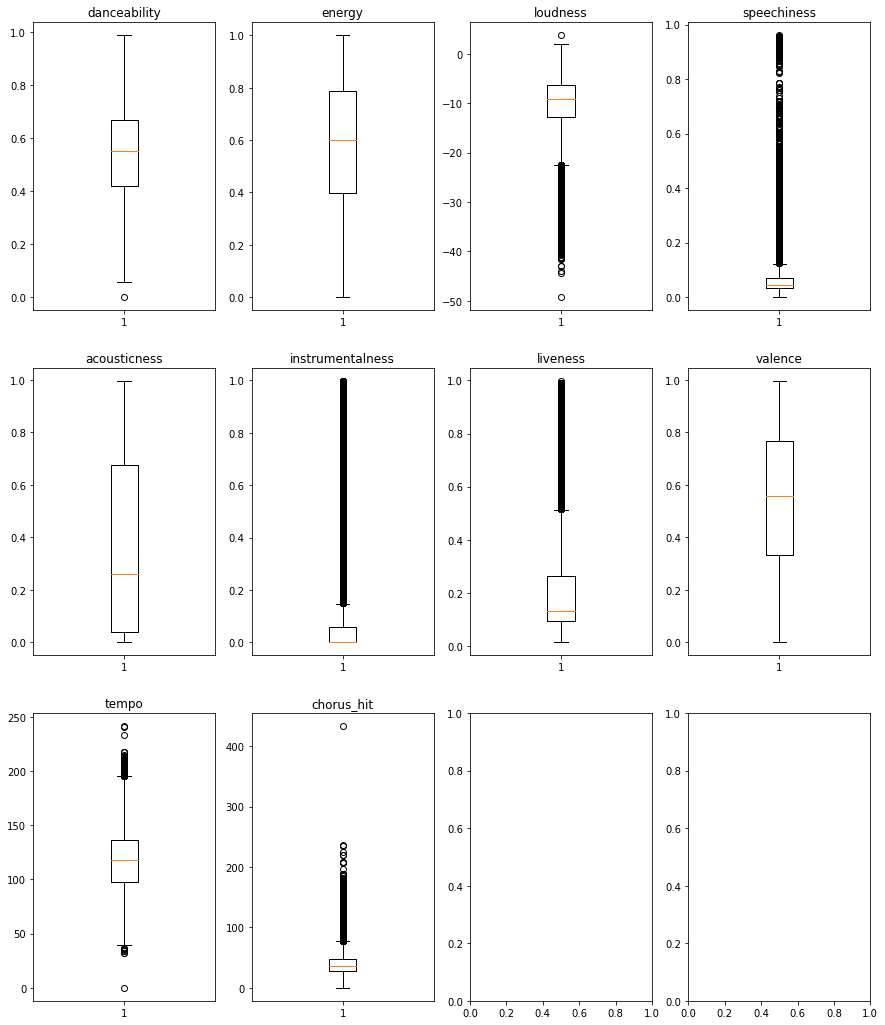

In [15]:
plt.rcParams["figure.figsize"] = (15,18)
figure, axis = plt.subplots(3, 4)


i = 0
for cols in df_dropped.select_dtypes(float).columns:
    y = i % 4
    x = i // 4 
    axis[x,y].boxplot(df_dropped[[cols]])
    axis[x,y].set_title(cols)
    i = i + 1
plt.show()

We note that speechiness, instrumentalness, liveness, and chorus_hit are all right skewed and that loudness is left skewed. Although we also note that chorus_hit has one massive outlier that we may want to investigate.

In [16]:
df_dropped = df_dropped.drop(df_dropped['chorus_hit'].idxmax())

Now we will look at some of the integer variables. What is interesting is some of these are essentially continuous, which will be further shown after this set of plots.

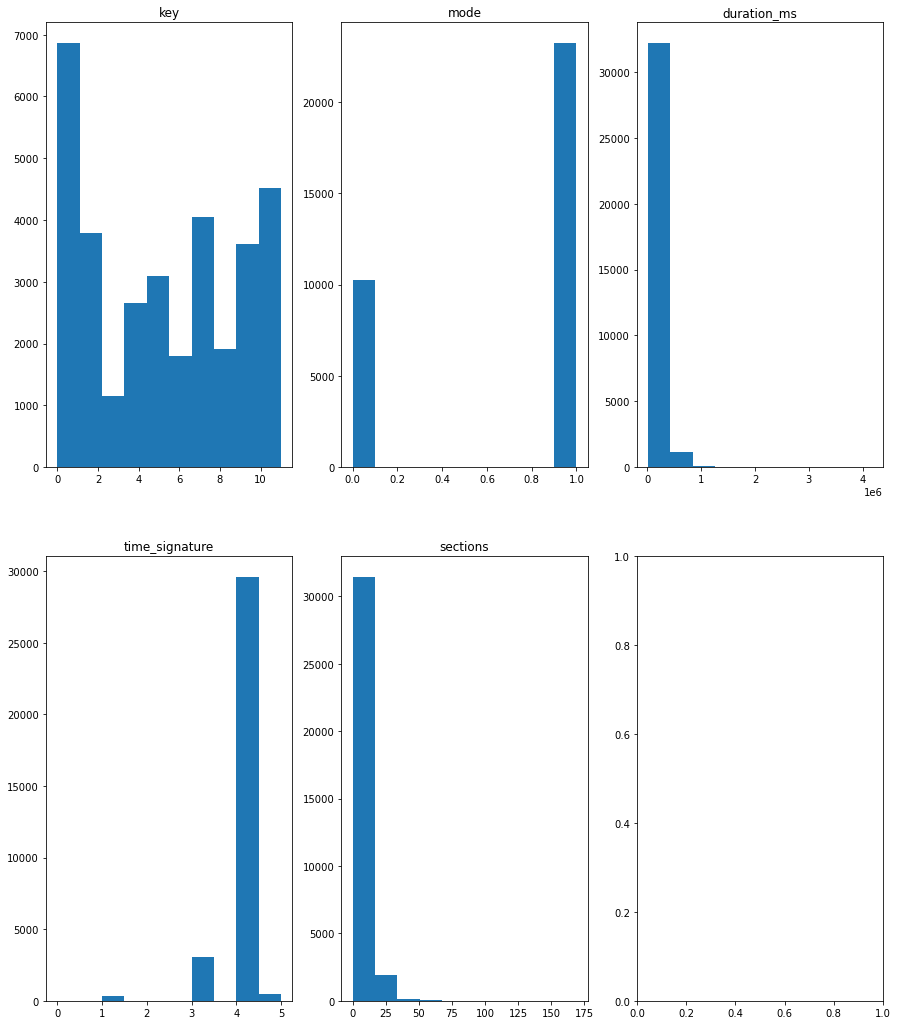

In [17]:
figure, axis = plt.subplots(2, 3)

i = 0
for cols in df_dropped.select_dtypes('int64').columns:
    y = i % 3
    x = i // 3 
    axis[x,y].hist(df_dropped[[cols]])
    axis[x,y].set_title(cols)
    i = i + 1

    plt.rcParams["figure.figsize"] =  (6.4, 4.8)
plt.show()

The mode and key plots dont seem to have an issue with having too few observations in a bin, although the time signature variable might. Also, the key of C (or key 0) seems to be the most common. The duration ms and sections will be further looked at below by logging them to see their continuity

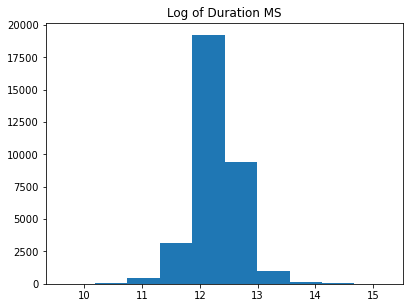

In [18]:
plt.hist(np.log(df_dropped['duration_ms']))
plt.title('Log of Duration MS')
plt.show()

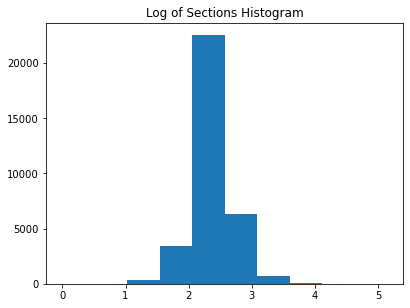

In [19]:
plt.hist(np.log(df_dropped['sections']+1))
plt.title('Log of Sections Histogram')
plt.show()

In [20]:
df_dropped['time_signature'].value_counts()

4    29573
3     3091
5      481
1      309
0        2
Name: time_signature, dtype: int64

In [21]:
df_dropped['hit'].value_counts()

1    16845
0    16611
Name: hit, dtype: int64

In [22]:
df_dropped['decade'].value_counts()

1960    7062
1970    6329
1980    5600
2010    5151
2000    4793
1990    4521
Name: decade, dtype: int64

In [23]:
df_dropped['hit_last_decade'].value_counts()

0    28794
1     4662
Name: hit_last_decade, dtype: int64

In [24]:
def cleaner(dat):
    # Since there are only 3 total 0 time signatures between both datasets I convert them to the 
    # nearest time signature both in beats per measure and in number of values which is 1
    dat.loc[dat.loc[dat['time_signature']==0].index,'time_signature'] = 1
    # Making dummy variables so we can use the time signatures properly
    dat[['signature_1', 'signature_3', 'signature_4', 'signature_5']] = pd.get_dummies(dat['time_signature'])
    df_dummy_key = pd.get_dummies(dat['key'], prefix = 'key_', drop_first = True)
    dat = dat.merge(df_dummy_key, left_index=True, right_index=True)
    df_dummy_time = pd.get_dummies(dat['decade'], prefix = 'year_', drop_first = True)
    dat = dat.merge(df_dummy_time, left_index=True, right_index=True)

    '''
    Dropping the 4 time signature (this is the most common so its the base comparison).
    Dropping the first year in the list for a base comparison, and getting rid of the original
    time signature and decade variables. Also removing the artists, uri, and track. 
    '''
    dat = dat.drop(columns = ['artist', 'uri', 'track', 'signature_4', 'time_signature', 'decade', 'key'])
    return dat

In [25]:
df_final = cleaner(df_dropped)
df_missing = cleaner(df_na)

In [26]:
df_final.describe(include = ['uint8'])

,signature_1,signature_3,signature_5,key__1,key__2,key__3,key__4,key__5,key__6,key__7,key__8,key__9,key__10,key__11,year__1970,year__1980,year__1990,year__2000,year__2010
count,33456.000000,33456.00000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000,33456.00000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000,33456.000000
mean,0.009296,0.09239,0.014377,0.080673,0.113343,0.034403,0.079537,0.09239,0.053862,0.120995,0.057359,0.108052,0.066565,0.068508,0.189174,0.167384,0.135133,0.143263,0.153963
std,0.095967,0.28958,0.119041,0.272337,0.317016,0.182266,0.270580,0.28958,0.225748,0.326126,0.232531,0.310451,0.249271,0.252619,0.391653,0.373324,0.341870,0.350346,0.360919
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df_missing.describe(include = ['uint8'])

,signature_1,signature_3,signature_5,key__1,key__2,key__3,key__4,key__5,key__6,key__7,key__8,key__9,key__10,key__11,year__1970,year__1980,year__1990,year__2000,year__2010
count,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000
mean,0.008480,0.096514,0.014268,0.075649,0.108763,0.037017,0.085341,0.090860,0.053978,0.120070,0.055728,0.111724,0.065554,0.067035,0.187643,0.173509,0.132723,0.143223,0.153049
std,0.091703,0.295314,0.118603,0.264454,0.311363,0.188816,0.279408,0.287429,0.225989,0.325065,0.229410,0.315048,0.247517,0.250099,0.390453,0.378712,0.339298,0.350323,0.360059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Predictive Modeling

The result function can help to more easily get the prediction metrics for the models

In [28]:
def results(test, pred): # This function calculates the accuracy precision and recall of a given model
    accuracy = accuracy_score(test, pred)
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    data = [['Accuracy', accuracy], ['Precision', precision], ['Recall', recall]]
    results_df = pd.DataFrame(data, columns = ['Metric', 'Result'])
    return results_df


Split into training and testing data. This is most important for the gradient boost but is overall nice to see anyway.

In [29]:
y_vals = df_final['hit']
x_vals = df_final.drop(columns = 'hit')
#x_vals = df_final.drop(columns = ['year_1970', 'year_1980', 'year_1990', 'year_2000', 'year_2010', 'hit'])

x_train, x_test, y_train, y_test = train_test_split(x_vals, np.asarray(y_vals).ravel(), test_size=TESTING_SIZE,
                                                    random_state=RAND)

The first model is the random forest. I will look at the model and then check the variable importances. 

In [30]:
rf = RandomForestClassifier(bootstrap=True, random_state=RAND, criterion='gini', min_samples_split=150,
                           n_estimators=ESTIMATORS)
model_rf = rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)
rf_results = results(y_test, y_pred_rf)
print(tabulate(rf_results, tablefmt="grid", headers="keys"))

+----+-----------+----------+
|    | Metric    |   Result |
+====+===========+==========+
|  0 | Accuracy  | 0.808129 |
+----+-----------+----------+
|  1 | Precision | 0.79313  |
+----+-----------+----------+
|  2 | Recall    | 0.831533 |
+----+-----------+----------+


Next I am going to plot the 5 most important features in the random forest. 

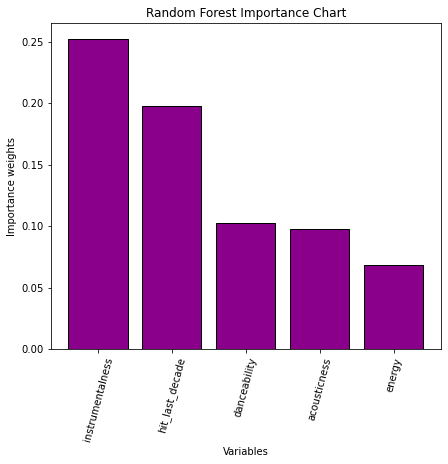

In [31]:
variable_list = x_train.columns
features = model_rf.feature_importances_
sorted = np.argsort(-features)
weights = features[sorted][0:5]
importances = list(weights)
x_values = list(range(len(importances)))
fig_1 = plt.figure(figsize=(7, 6))
plt.bar(x_values, importances, orientation='vertical', color = 'darkmagenta', edgecolor = 'black')
plt.xticks(x_values, variable_list[sorted][0:5], rotation=75)
plt.title('Random Forest Importance Chart')
plt.ylabel('Importance weights')
plt.xlabel('Variables')
plt.show()

The second model is a gradient boosted tree. I will look at the model and then check the variable importances. 

In [32]:

gradient = GradientBoostingClassifier(learning_rate=.35, n_estimators=ESTIMATORS,
                                     random_state=RAND)
model_grad = gradient.fit(x_train, y_train)
y_pred_grad = model_grad.predict(x_test)
grad_results = results(y_test, y_pred_grad)
print(tabulate(grad_results, tablefmt="grid", headers="keys"))

+----+-----------+----------+
|    | Metric    |   Result |
+====+===========+==========+
|  0 | Accuracy  | 0.83423  |
+----+-----------+----------+
|  1 | Precision | 0.819962 |
+----+-----------+----------+
|  2 | Recall    | 0.854742 |
+----+-----------+----------+


Like before I will make an importance plot of the variables in this gradient boosted model.

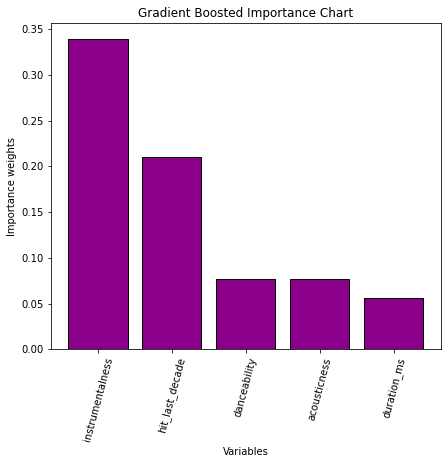

In [33]:
variable_list = x_train.columns
features = model_grad.feature_importances_
sorted = np.argsort(-features)
weights = features[sorted][0:5]
importances = list(weights)
x_values = list(range(len(importances)))
fig_2 = plt.figure(figsize=(7, 6))
plt.bar(x_values, importances, orientation='vertical', color = 'darkmagenta', edgecolor = 'black')
plt.xticks(x_values, variable_list[sorted][0:5], rotation=75)
plt.title('Gradient Boosted Importance Chart')
plt.ylabel('Importance weights')
plt.xlabel('Variables')
plt.show()

The final model is a logistic regression.

In [34]:
log_mod = Logit(y_train, x_train).fit()
print(log_mod.summary())

Optimization terminated successfully.
         Current function value: 0.441381
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28437
Model:                          Logit   Df Residuals:                    28404
Method:                           MLE   Df Model:                           32
Date:                Sun, 16 May 2021   Pseudo R-squ.:                  0.3632
Time:                        20:07:11   Log-Likelihood:                -12552.
converged:                       True   LL-Null:                       -19710.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
danceability         4.5578      0.119     38.377      0.000       4.325       4.791
energy    

In [35]:
params = log_mod.params
conf = log_mod.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(tabulate(np.exp(conf), tablefmt="grid", headers="keys"))

+------------------+-------------+-------------+--------------+
|                  |          5% |         95% |   Odds Ratio |
+==================+=============+=============+==============+
| danceability     |  75.5647    | 120.365     |   95.3697    |
+------------------+-------------+-------------+--------------+
| energy           |   0.326467  |   0.48848   |    0.39934   |
+------------------+-------------+-------------+--------------+
| loudness         |   1.08489   |   1.10677   |    1.09577   |
+------------------+-------------+-------------+--------------+
| mode             |   1.46369   |   1.6776    |    1.567     |
+------------------+-------------+-------------+--------------+
| speechiness      |   0.0370642 |   0.0819945 |    0.0551277 |
+------------------+-------------+-------------+--------------+
| acousticness     |   0.166312  |   0.215133  |    0.189154  |
+------------------+-------------+-------------+--------------+
| instrumentalness |   0.0288167 |   0.0

In [36]:
y_pred_log = round(log_mod.predict(x_test))
log_results = results(y_test, y_pred_log)
print(tabulate(log_results, tablefmt="grid", headers="keys"))

+----+-----------+----------+
|    | Metric    |   Result |
+====+===========+==========+
|  0 | Accuracy  | 0.772465 |
+----+-----------+----------+
|  1 | Precision | 0.766601 |
+----+-----------+----------+
|  2 | Recall    | 0.780712 |
+----+-----------+----------+


In [37]:
logit_na_pred = round(log_mod.predict(df_missing))
forest_na_pred = model_rf.predict(df_missing)
boosted_na_pred = model_grad.predict(df_missing)

# Summary

The models should all help to better understand what makes a hit song and to predict future hits. The gradient boosted tree had a performance of 83% accuracy on the testing data, and comporable precision and recall. This was the best of the models, but they all told similar stories about the data. The most important factors by importance weights, coefficients and significance levels, were instrumentalness, danceability, acousticness, and if the artist had a hit last decade. Furthermore it appears that the time signatures of the music are not important in making a hit and that 4 time is by far the most popular (not suprising, see 4chords songs video about normal music practices). Additionally, the length of the song, number of sections and the timing of the chorus seemed not to be important factors in making a hit song.   